In [127]:
import argparse
import yaml
import torch.backends.cudnn as cudnn
import torch
from PIL import Image
import numpy as np
import os
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage, ToTensor

from util import trainer_util, metrics
from util.iter_counter import IterationCounter
from models.dissimilarity_model import DissimNet, GuidedDissimNet, ResNetDissimNet, CorrelatedDissimNet
from util import visualization

In [142]:
# input parameters
config_file_path = 'configs/visualization/default_configuration.yaml'
gpu_ids = '15'
how_many = 10
#dataroot = '/home/giancarlo/data/innosuisse/fs_lost_and_found'
#dataroot = '/home/giancarlo/data/innosuisse/fs_static'
dataroot = '/home/giancarlo/data/innosuisse/road_anomaly'
#dataroot = '/home/giancarlo/data/innosuisse/epfl/train'

In [129]:
# load experiment setting
with open(config_file_path, 'r') as stream:
    config = yaml.load(stream, Loader=yaml.FullLoader)

In [130]:
# get experiment information
exp_name = config['experiment_name']
save_fdr = config['save_folder']
epoch = config['which_epoch']

In [131]:
# activate GPUs
config['gpu_ids'] = gpu_ids
gpu_info = trainer_util.activate_gpus(config)

In [132]:
# get model
if 'vgg' in config['model']['architecture'] and 'guided' in config['model']['architecture']:
    diss_model = GuidedDissimNet(**config['model']).cuda()
if 'vgg' in config['model']['architecture'] and 'correlated' in config['model']['architecture']:
    diss_model = CorrelatedDissimNet(**config['model']).cuda()
elif 'vgg' in config['model']['architecture']:
    diss_model = DissimNet(**config['model']).cuda()
elif 'resnet' in config['model']['architecture']:
    diss_model = ResNetDissimNet(**config['model']).cuda()
else:
    raise NotImplementedError()

In [133]:
# get model weights
diss_model.eval()
model_path = os.path.join(save_fdr, exp_name, '%s_net_%s.pth' %(epoch, exp_name))
model_weights = torch.load(model_path)
diss_model.load_state_dict(model_weights,  strict=False)
# NOTE: For old models, there were some correlation weights created that were not used in the foward pass. That's the reason to include strict=False

_IncompatibleKeys(missing_keys=[], unexpected_keys=['corr1.weight', 'corr1.bias', 'corr2.weight', 'corr2.bias', 'corr3.weight', 'corr3.bias', 'corr4.weight', 'corr4.bias'])

In [134]:
# neccesary functions
softmax = torch.nn.Softmax(dim=1)
to_pil = ToPILImage()

In [135]:
# get data_loaders
cfg_test_loader = config['test_dataloader']
cfg_test_loader['dataset_args']['dataroot'] = dataroot
test_loader = trainer_util.get_dataloader(cfg_test_loader['dataset_args'], cfg_test_loader['dataloader_args'])
batch_size = cfg_test_loader['dataloader_args']['batch_size']

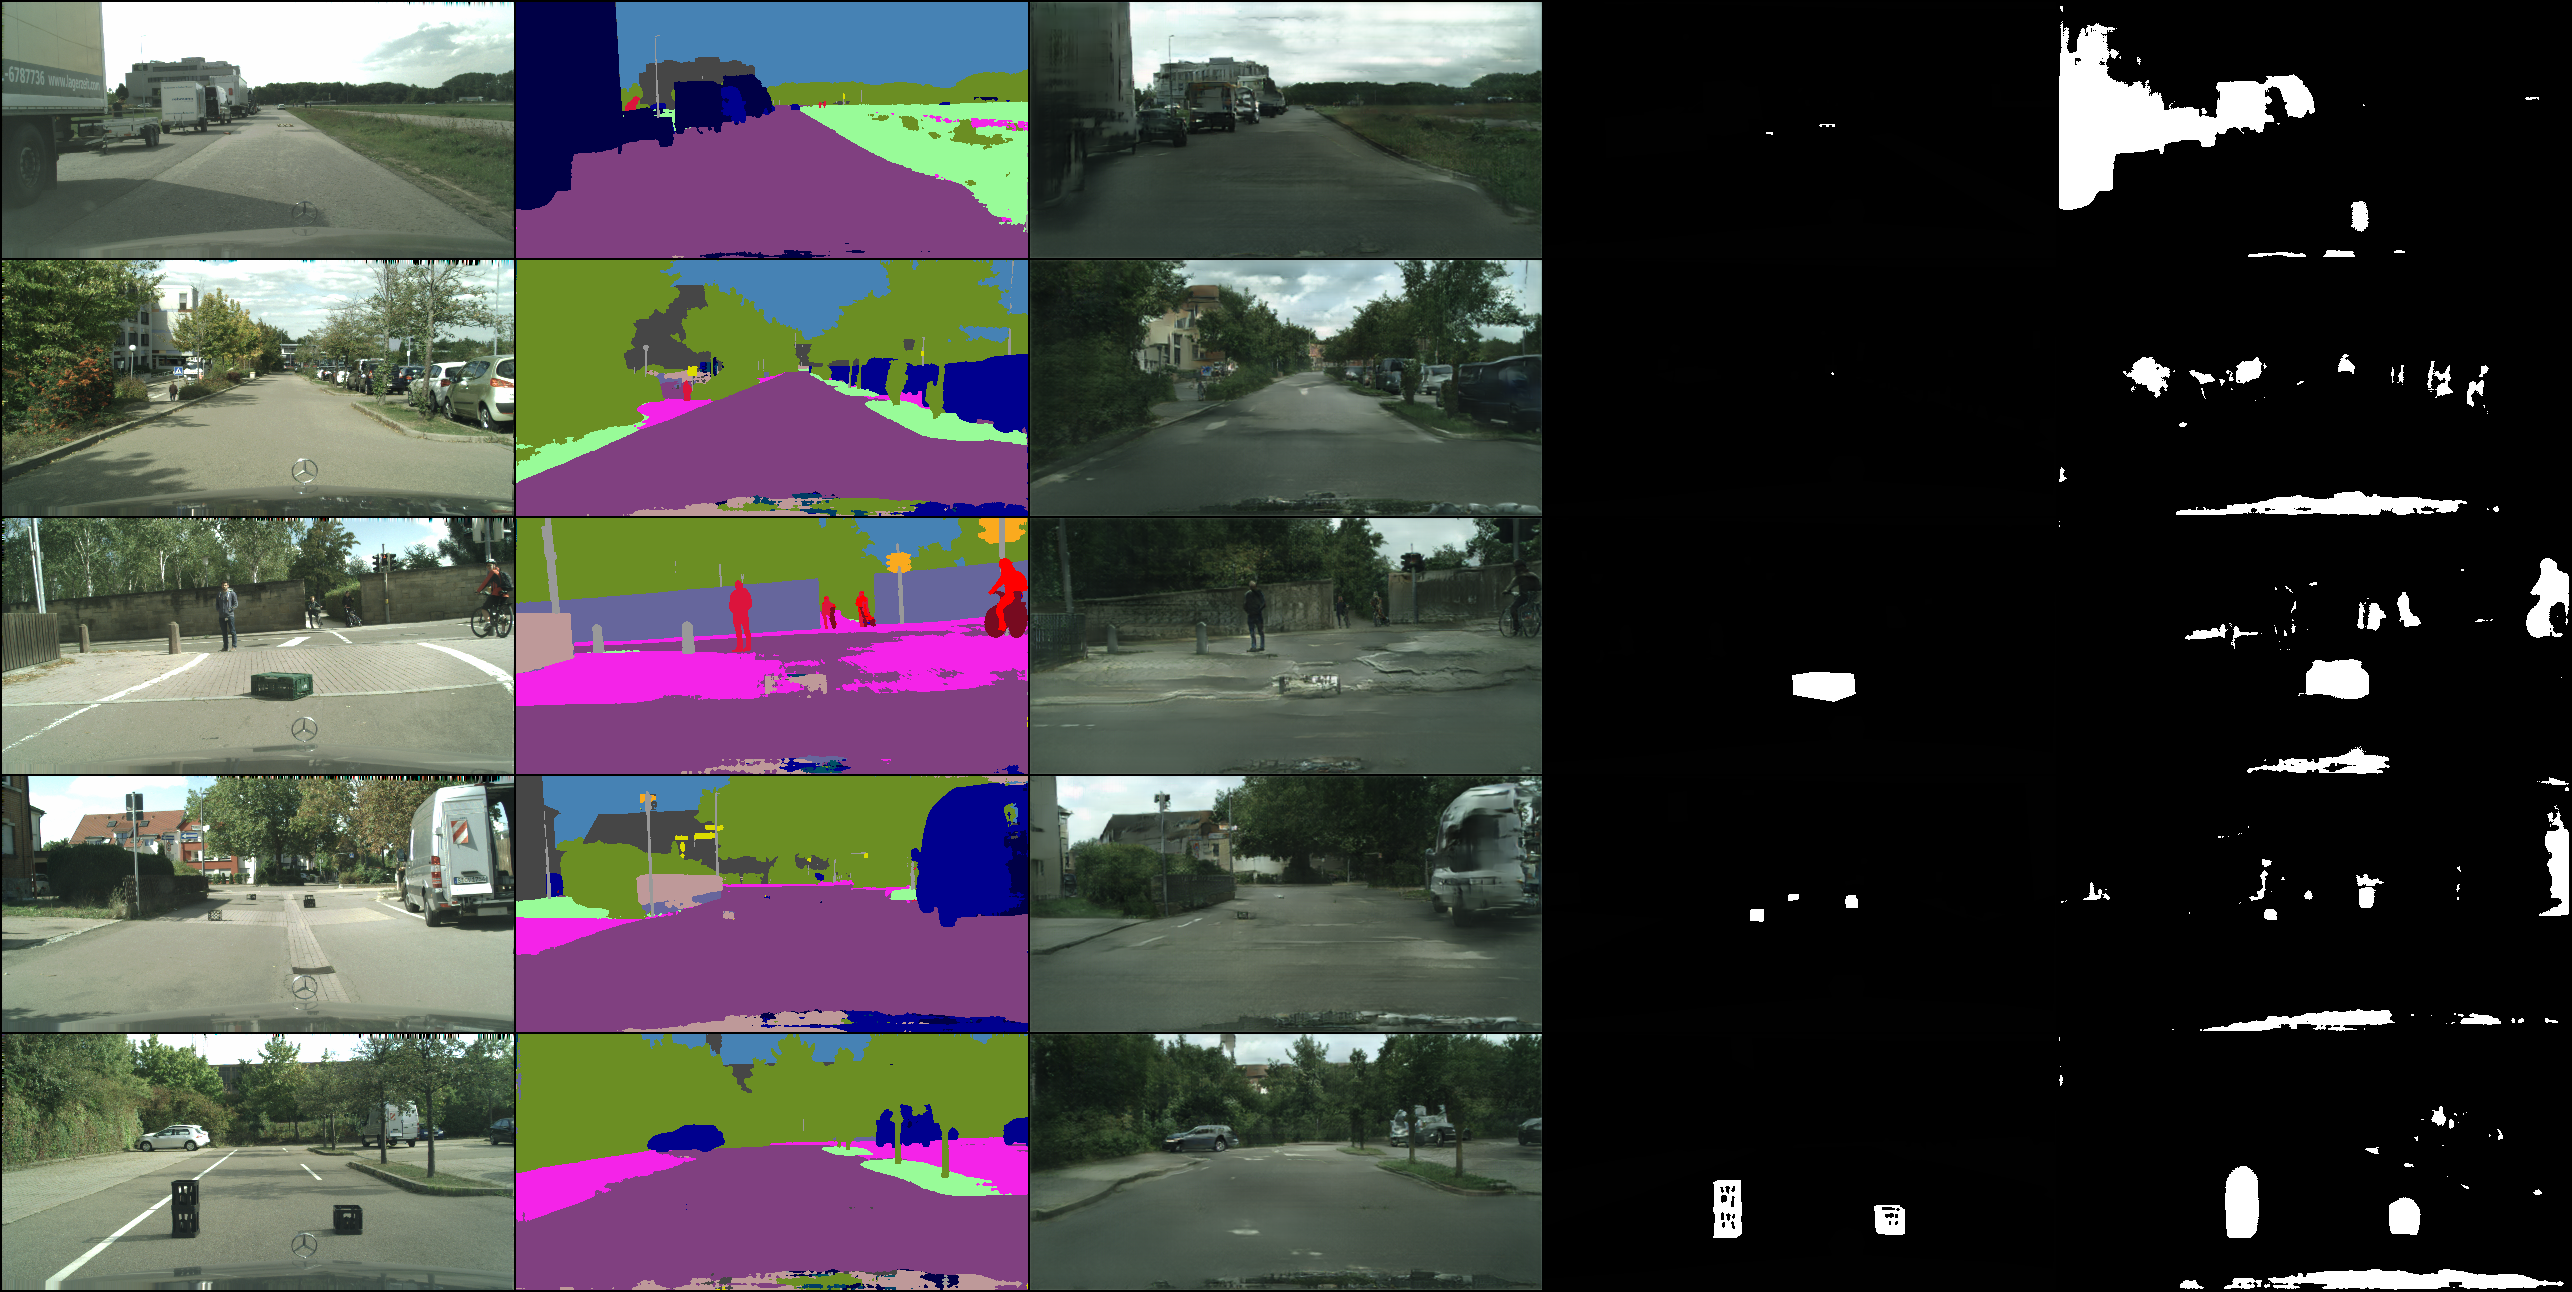

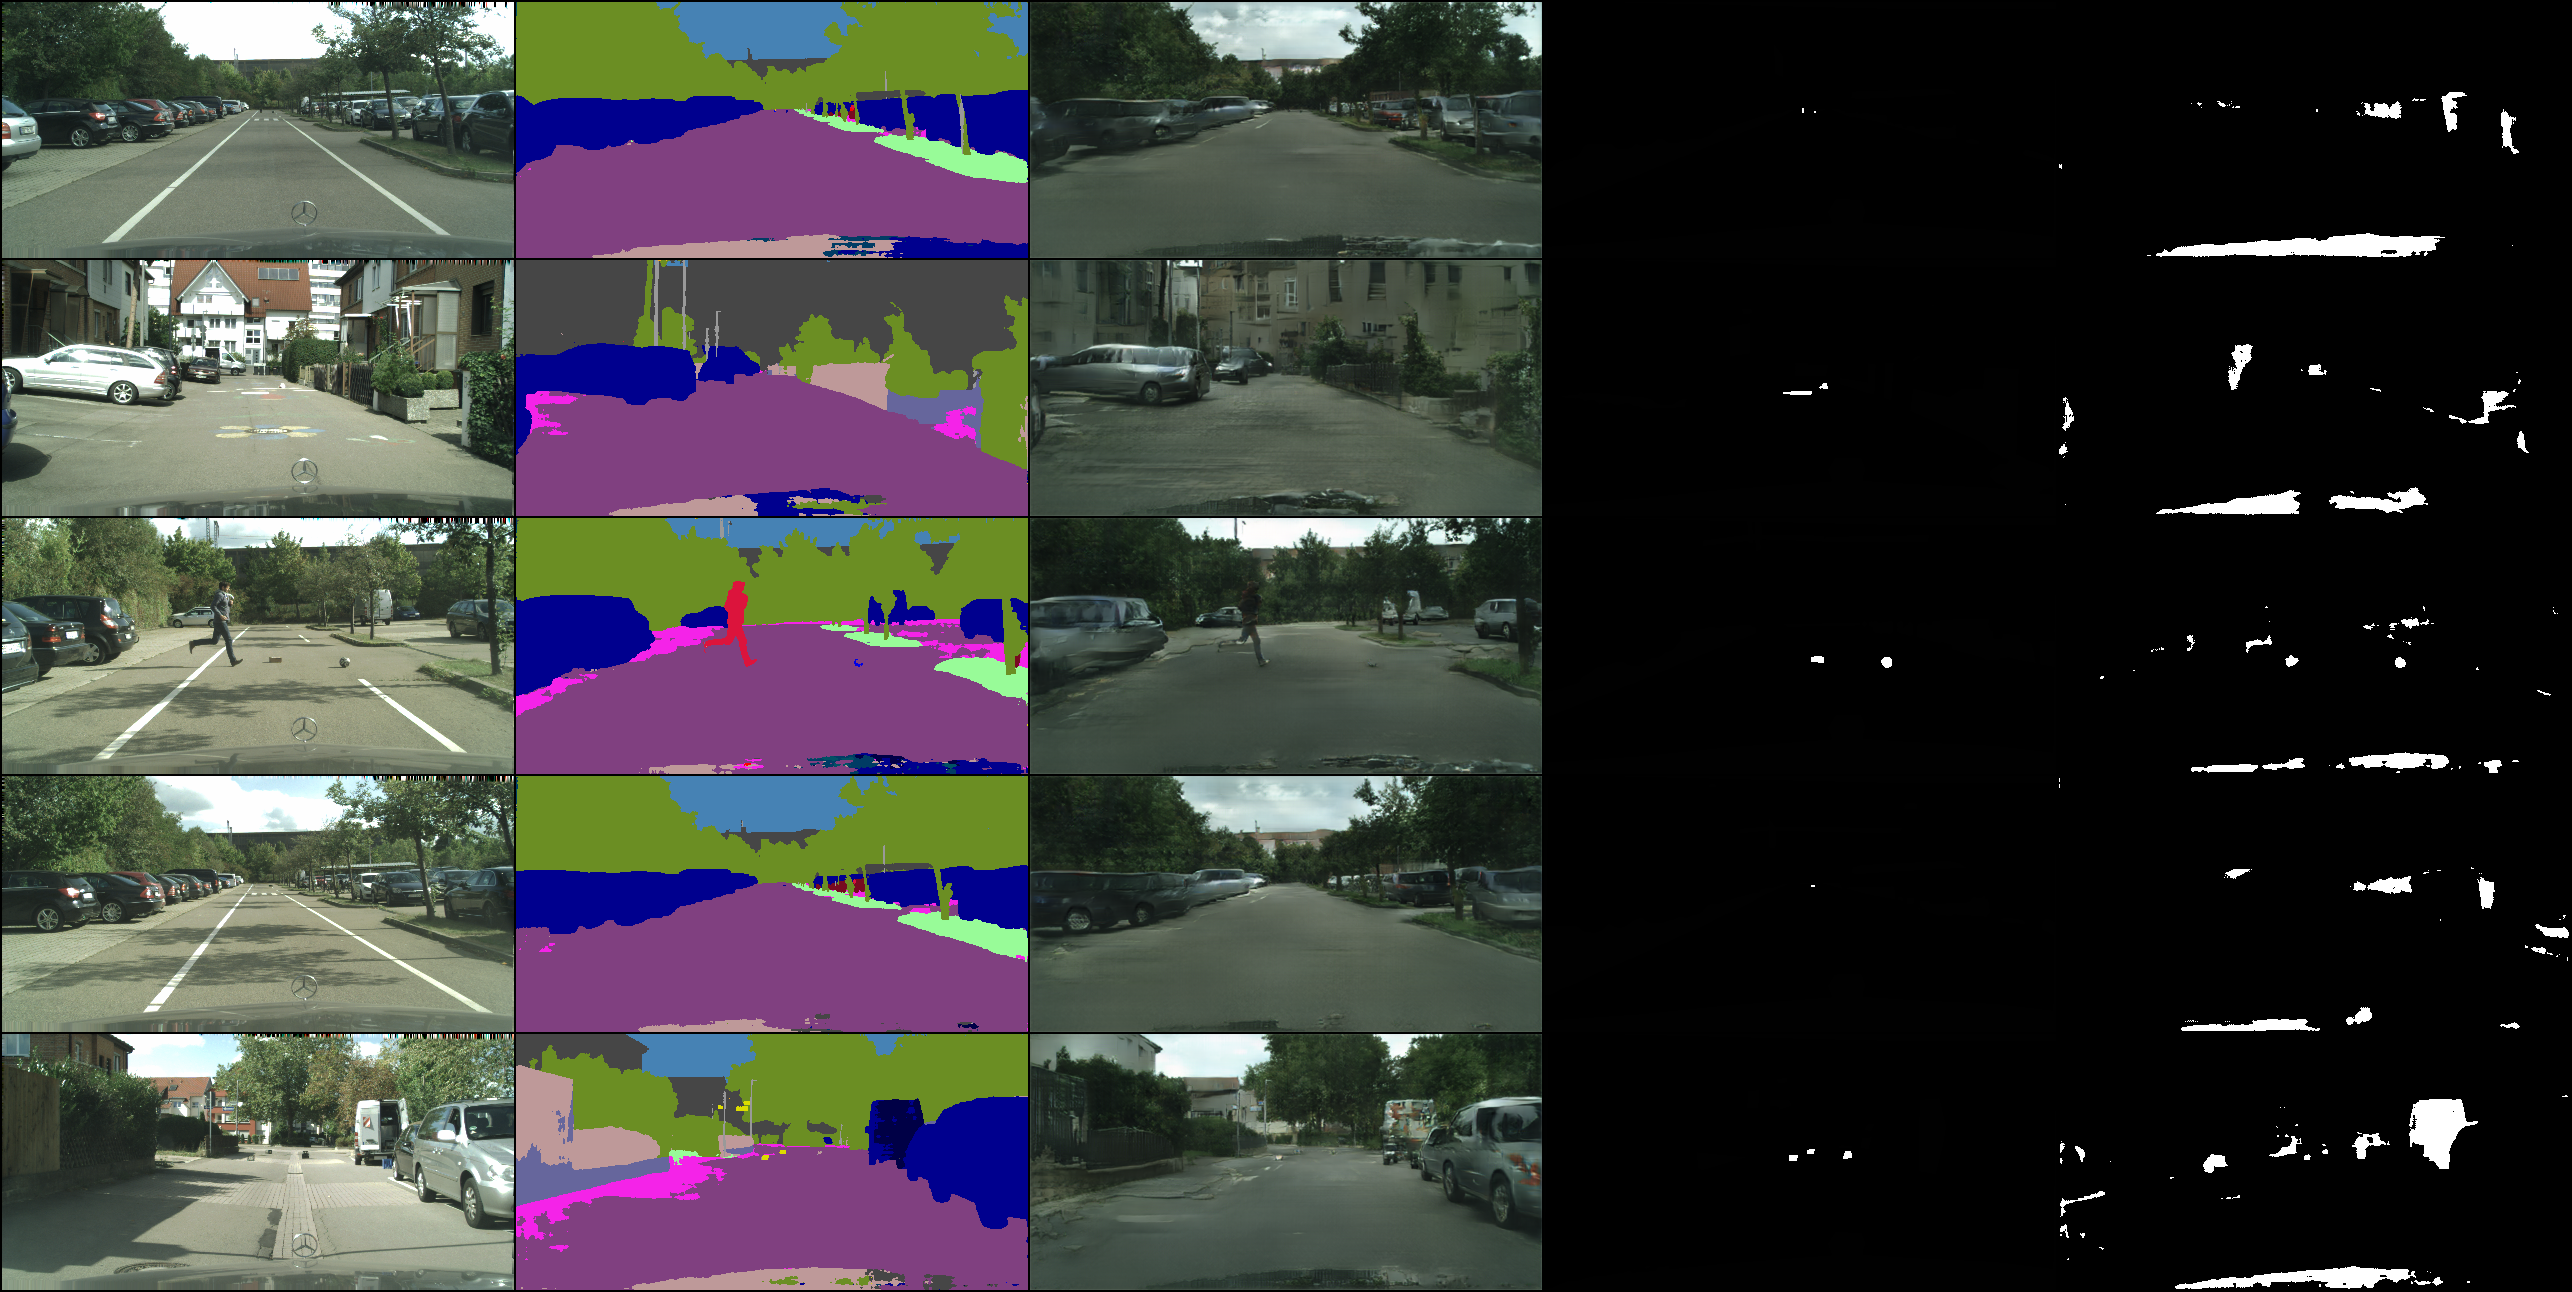

In [141]:
# Going through visualization loader
with torch.no_grad():
    for i, data_i in enumerate(test_loader):
        original = data_i['original'].cuda()
        semantic = data_i['semantic'].cuda()
        synthesis = data_i['synthesis'].cuda()
        label = data_i['label'].cuda()

        # Evaluating
        outputs = softmax(diss_model(original, synthesis, semantic))
        (softmax_pred, predictions) = torch.max(outputs, dim=1)

        # post processing for semantic, label and prediction
        semantic_post = torch.zeros([original.shape[0], 3, 256, 512])
        for idx, semantic_ in enumerate(semantic):
            (_, semantic_) = torch.max(semantic_, dim = 0)
            semantic_ = 256 - np.asarray(ToPILImage()(semantic_.type(torch.FloatTensor).cpu()))
            semantic_[semantic_ == 256] = 0
            semantic_ = visualization.colorize_mask(semantic_)
            semantic_ = ToTensor()(semantic_.convert('RGB'))
            semantic_post[idx, :, :, :] = semantic_

        label_post = torch.zeros([original.shape[0], 3, 256, 512])
        for idx, label_ in enumerate(label):
            label_ = np.asarray(ToPILImage()(label_.type(torch.FloatTensor).cpu()))
            label_ = ToTensor()(Image.fromarray(label_).convert('RGB'))
            label_post[idx, :, :, :] = label_

        predictions_post = torch.zeros([original.shape[0], 3, 256, 512])
        for idx, predictions_ in enumerate(predictions):
            predictions_ = np.asarray(ToPILImage()(predictions_.type(torch.FloatTensor).cpu()))
            predictions_ = ToTensor()(Image.fromarray(predictions_).convert('RGB'))
            predictions_post[idx, :, :, :] = predictions_

        all_images = torch.zeros([original.shape[0]*5, 3, 256, 512])
        for idx, (original_img, semantic_img, synthesis_img, label_img, predictions_img) in \
                enumerate(zip(original, semantic_post, synthesis, label_post, predictions_post)):
            all_images[idx*5, :, :, :] = original_img
            all_images[idx*5+1, :, :, :] = semantic_img
            all_images[idx*5+2, :, :, :] = synthesis_img
            all_images[idx*5+3, :, :, :] = label_img
            all_images[idx*5+4, :, :, :] = predictions_img
        grid = make_grid(all_images, 5)
        grid = to_pil(grid)
        display(grid)
        if (batch_size * i+5) >= how_many:
            break